# Challenge : Humpback Whale Identification

> Ce Challenge de Kaggle qui a pour destination l'identification du nom de baleines déjà identifiées (et "labelisées")
    - Dans le cas où celle-ci n'est pas 'connue' elle doit être catégorisée comme étant `new_whale`
Le fichier de soumission doit contenir le nom de l'image de test ainsi que 5 prédictions de noms de baleines<br>
Le fait d'ajouter un 2e, 3e ... nom ne pénalise pas plus, il est donc souhaitable de remplir les 5 noms possibles.<br>
Le résultat prend en compte l'ordre de prédiction des noms
    - le bon nom de classe proposé en 1e position obtiendra 1 
    - le bon nom est en position 2 : 1/2
    - en 3 : 1/3
    - en 4 : 1/4
    - en 5 : 1/5
C'est la moyenne des notes de toutes les images qui est la mesure de performance

<div class="alert alert-block alert-warning">
$$MAP@5=\frac{1}{U}\sum_{u=1}^{U}\sum_{k=1}^{min(n,5)}P(k)×rel(k)$$<br>
<center>où</center>
- U est le nombre d'images<br>
- P(k) est la précision à l'index k<br>
- n le nombre de prédiction pour l'image<br>
- rel(k) la fonction indicatrice qui vaut 1 si le label à la position k est juste 0 sinon<br>
</div>


<div class="alert alert-block alert-success">
<b>Tests Naifs:</b>
<br>Des tests naïfs de soumission de fichiers de résultats ont été faits et relèvent ainsi<br>
1. Soumission_V0 : Reprise du fichier d'origine avec les noms des bonnes images -> `0.277 [place 1759]`<br>
    &nbsp;&nbsp;&nbsp;   'new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c' pour chaque image<br>
2. Soumission_V1 : Le fichier reprend new_whale en 2e position -> `0.139`<br>
    &nbsp;&nbsp;&nbsp;    'w_23a388d new_whale w_9b5109b w_9c506f6 w_0369a5c'<br>
<br>
<b>A cette heure :</b><br> 
- 1981 participants<br>
--> Les notes se basent sur seulement 20 % des données du fichier de soumission</div>

# PLAN

<h2><font color=blue>[1. Exploration des Données](#section1)</font></h2><br>
1. [Découverte des données](#section1.1)<br>
1. [Visualisation des Images](#section1.2)<br>
1. [Répartition des Données](#section1.3)<br>
    
<h2><font color=blue>[2. Problèmes soulevés par ce Challenge](#section2)</font></h2><br>
1. [La problématique Générale du KAGGLE](#section2.1)<br>
    1. [Stratégie Globale](#section2.1.1)<br>
    1. [Stratégie particulières](#section2.1.2)<br>
1. [Les Difficultés liées aux données](#section2.2)<br>
    1. [Transfer Learning](#section2.2.1)<br>
    1. [Data Augmentation](#section2.2.2)<br>

<h2><font color=blue>[3. La Modélisation](#section3)</font></h2><br>
1. [CNN](#section3.1)<br>
1. [Process](#section3.2)<br>
1. [Pré-Traitement sur les Images](#section3.3)<br>

<h2><font color=blue>[4. Les Résultats de la modélisation](#section4)</font></h2><br>
1. [L'entrainement](#section4.1)<br>
1. [Les Résultats](#section4.2)<br>
1. [Faux Bon résultat](#section4.3)<br>

<h2><font color=blue>[5. CONCLUSION](#section5)</font></h2><br>

<a id='section1'></a>

# Exploration des Données

In [1]:
dir_data = './../DATAS/data/'

dir_image_train = dir_data + 'train/'
dir_image_test = dir_data + 'test/'
csv_file = dir_data + 'train.csv'

#### Librairies 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
## Fonctions Utiles
from keras.preprocessing.image import ImageDataGenerator, image
from Utils import TransformImage

Using TensorFlow backend.


<a id='section1.1'></a>

## Découverte des Données

In [5]:
df_train = pd.read_csv(csv_file)
df_train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
df_train.shape, len(os.listdir(dir_image_train)), len(os.listdir(dir_image_test))

((25361, 2), 25361, 7960)

In [7]:
len(set(list(df_train.Image))-set(os.listdir(dir_image_train)))

0

> Nous avons donc 25 361 images dans le répertoire d'entrainement, avec les mêmes noms d'images que celles du fichier 'train.csv' 

> Nous avons 7 960 images dans le répertoire de test pour générer les fichiers de soumission

<a id='section1.2'></a>
## Visualisation des Images
-----

In [8]:
df_train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [15]:
def image_with_index(idx):
    return np.array(image.load_img(dir_image_train + df_train.loc[idx].Image))

def image_name_id_from_index(idx):
    val = df_train.loc[idx]
    return '{} / {}'.format(val['Image'], val['Id'])

def get_image_name_id_from_index(idx):
    return df_train.loc[idx]['Image']

def image_with_name(image_name):
    return np.array(image.load_img(dir_image_train + image_name))

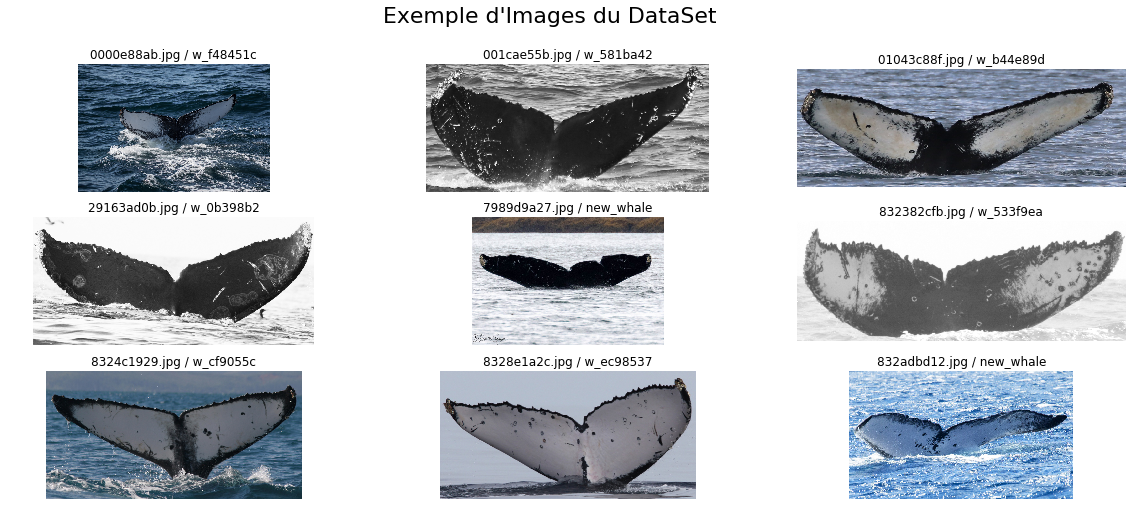

In [10]:
l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]

fig, ax = plt.subplots(3, 3, figsize=(20, 8))
ax = ax.ravel()

for idx_axe, idx_image in enumerate(l_index_image_dataSet):
    ax[idx_axe].imshow(image_with_index(idx_image))
    ax[idx_axe].axis('off')
    ax[idx_axe].set_title(image_name_id_from_index(idx_image))

plt.suptitle("Exemple d'Images du DataSet", fontsize=22)
plt.show()

> Regardons des Images appartenant à la même classe

<a id='section1.3'></a>
## Répartition des Données
-----
> Nous allons regarder la distribution des données en fréquence

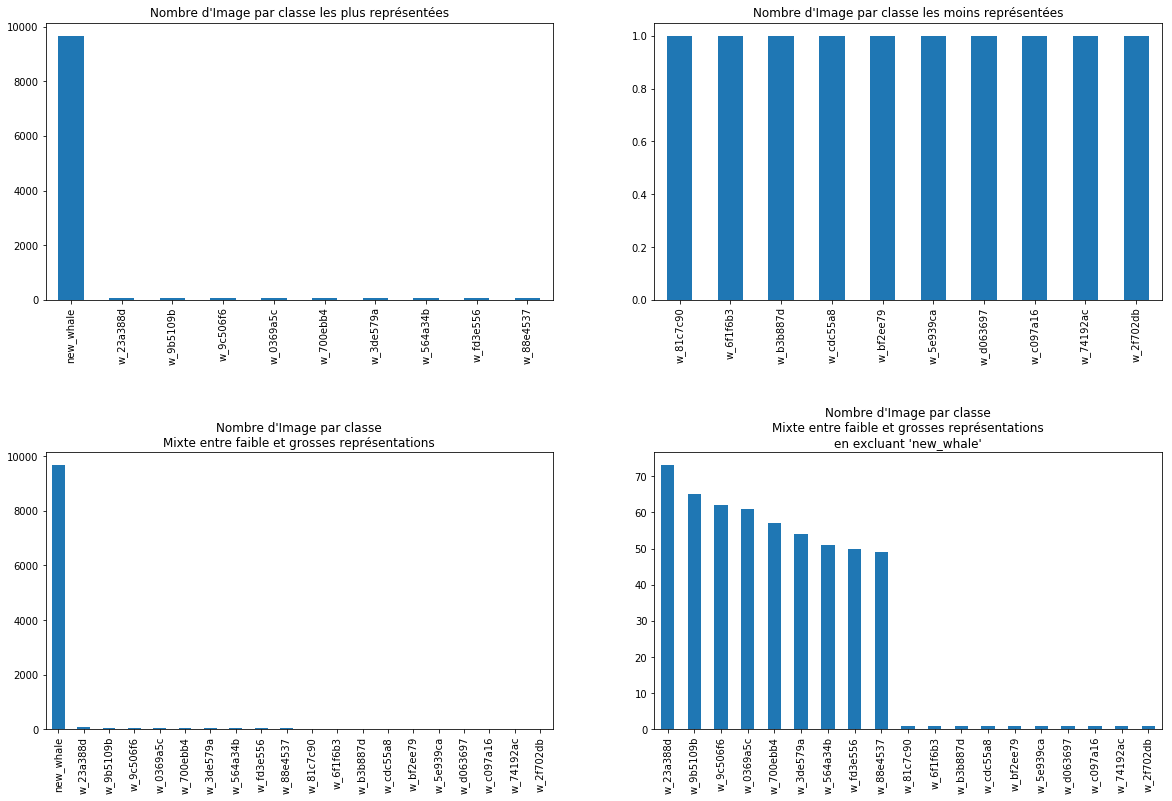

In [11]:
Head = df_train.Id.value_counts().sort_values(ascending=False).head(10)
Tail = df_train.Id.value_counts().sort_values(ascending=False).tail(10)
All = df_train.Id.value_counts().sort_values(ascending=False)
t2 = pd.concat([Head, Tail])

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
fig.subplots_adjust(hspace=0.55)
ax = ax.ravel()

u1 = Head.plot(kind='bar', ax=ax[0],  title="Nombre d'Image par classe les plus représentées")
Tail.plot(kind='bar', ax=ax[1], title="Nombre d'Image par classe les moins représentées")
t2.plot(kind='bar', ax=ax[2],  title="Nombre d'Image par classe\nMixte entre faible et grosses représentations")
t2[t2.values<2000].plot(kind='bar', ax=ax[3],  title="Nombre d'Image par classe\n"
                        "Mixte entre faible et grosses représentations\nen excluant 'new_whale'")

plt.show()

In [302]:
def affiche_exemple_image_meme_class(CLASS_NAME):
    l_index_image_dataSet = list(df_train[df_train.Id==CLASS_NAME].index[:3])

    fig, ax = plt.subplots(1, 3, )
    fig.set_size_inches(15, 4, forward=True)
    ax = ax.ravel()

    for idx_axe, idx_image in enumerate(l_index_image_dataSet):
        ax[idx_axe].imshow(image_with_index(idx_image))
        ax[idx_axe].axis('off')
        ax[idx_axe].set_title(image_name_id_from_index(idx_image))

    plt.suptitle("Exemple d'Images de la classe {}".format(CLASS_NAME), fontsize=22)
    plt.show()

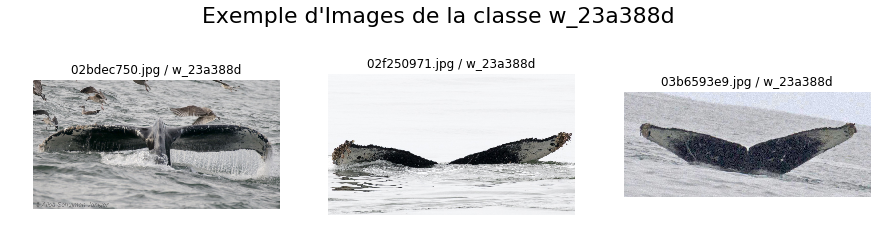

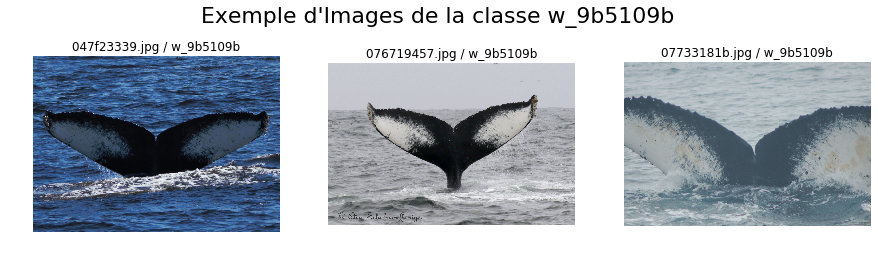

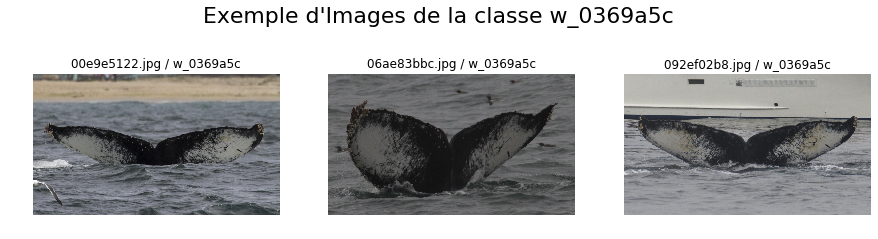

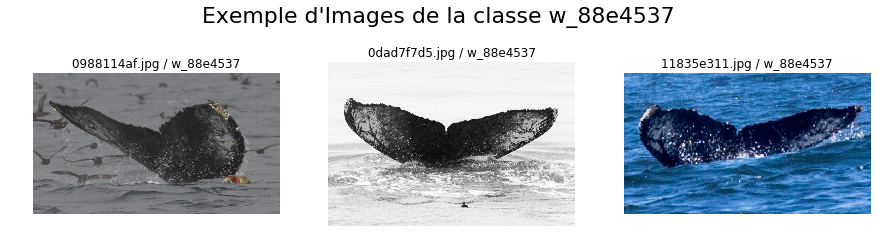

In [305]:
affiche_exemple_image_meme_class(CLASS_NAME = 'w_23a388d')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_9b5109b')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_0369a5c')
affiche_exemple_image_meme_class(CLASS_NAME = 'w_88e4537')

In [12]:
# Nombre d'images pour les classes les plus représentées
Head

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
Name: Id, dtype: int64

In [13]:
print('Nombre de classes différentes : ', df_train.Id.nunique())

Nombre de classes différentes :  5005


> on remarque une disparité très importante entre la représentation de 'new_whale' (c'est normal) et les autres

In [64]:
def tag_from_frequence(freq_in):
    if freq_in>=1000: return '[ 80, $\infty$ ['
    elif freq_in>=50: return '[ 50, 80 ['
    elif freq_in>=20: return '[ 20, 50 ['
    elif freq_in>=10: return '[ 10, 20 ['
    elif freq_in>=6: return '[ 6, 10 ['
    elif freq_in>=5: return '[ 5 ]'
    elif freq_in>=4: return '[ 4 ]'
    elif freq_in>=3: return '[ 3 ]'
    elif freq_in>=2: return '[ 2 ]'
    else: return '[ 1 ]'
    
def tag_from_frequence_order(freq_in):
    if freq_in>=1000: return 16
    elif freq_in>=50: return 15
    elif freq_in>=20: return 14
    elif freq_in>=10: return 13
    elif freq_in>=6: return 12
    elif freq_in>=5: return 11
    elif freq_in>=4: return 10
    elif freq_in>=3: return 9
    elif freq_in>=2: return 8
    else: return 0

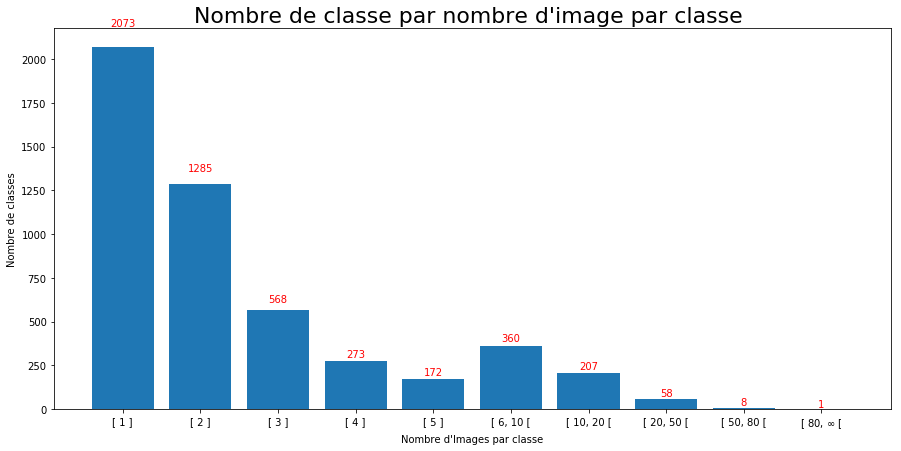

In [65]:
ensembles = [ tag_from_frequence(x) for x in df_train.Id.value_counts().values]
ensembles_ord = [ tag_from_frequence_order(x) for x in df_train.Id.value_counts().values]
t1 = pd.DataFrame({'Ensemble':ensembles, 'Ordre':ensembles_ord})
t2 = t1.groupby(['Ensemble', 'Ordre']).size().reset_index(name='Freq')
t2.sort_values(by=['Ordre'], inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(15, 7, forward=False)
rect1 = plt.bar(x=t2['Ensemble'], height=t2['Freq'], data=t2['Freq'])
plt.title("Nombre de classe par nombre d'image par classe ", fontsize=22)
plt.xlabel("Nombre d'Images par classe")
plt.ylabel("Nombre de classes")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom', color='red')

autolabel(rect1)
plt.show()

<a id='section2'></a>
# Problèmes soulevés par ce Challenge
-----

<a id='section2.1'></a>
## La problématique Générale du KAGGLE
-----
<div class="alert alert-block alert-info">
<b>RAPPEL : </b><br> 
Le dépôt du résultat se fait sous la forme d'un fichier comprenant pour chaque image à prédire, une liste de 5 noms de classe de baleine.<br><br> 
Si la bonne classe est identifiée, sa place dans la liste de 5 noms proposés rapporte plus ou moins de 'points'
La moyenne des points pour l'ensemble des 7 960 images nous donne le score pour le challenge.
</div>

<div class="alert alert-block alert-warning">
<b>A titre d'exemple:</b> Le fichier 'template' de résultat proposé, comprenant "new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c" comme propositions de noms pour chaque image obtient (à l'analyse actuelle de 20% des prédictions de notre fichier) un score de 0.277.<br>
-> Sachant que les images labellisées 'new_whale' représentent 38 % des images de training.
</div>

<a id='section2.1.1'></a>
### Stratégie Globale
Une stratégie globale pour traiter cette problématique peut donc être de 
1. Modéliser l'appartenance de chaque image à une classe plutôt qu'à une autre : problématique de classification
2. Proposer la liste de 5 noms les plus probables (et leur probabilité individuelle de prédiction)
3. Ordonner la proposition de 5 noms selon ces probabilités, voire selon une 2e vérification de ces probabilités
4. La classe 'new_whale' est une classe 'fourre-tout', c'est à dire qu'on doit y mettre les images qui ne correspondent pas à la même classe qu'une image déjà vue et labellisée<br>
Il semble donc nécessaire de comparer les solutions entre 
    1. la détection à l'appartenance à cette classe 
    2. la non appartenance à une autre classe

<a id='section2.1.2'></a>
### Stratégies particulières
Afin de suivre la stratégie globale pour répondre aux besoins du Challenge j'ai défini 4 stratégies qui permettent de mettre de suivre celle-ci.
    1. Modéliser la classification (new_whale compris) : 
        -> Donner les 5 meilleurs score dans l'ordre (ou avec une pondération à définir)
    2. Modéliser la classification (new_whale compris) : 
        -> Etablir une notion de distance à l'appartenance de chaque classe pour ajouter un élément 'new_whale' et sa place à proposer dans la liste des propositions par l'établissement d'un seuil, par clustering, ...
    3. Modéliser la classification (en excluant les images labellisées 'new_whale') : 
        -> Donner les 5 meilleurs score pour la prédiction des images de test, modéliser la détection d'appartenance à 'new_whale' par rapport aux scores des noms proposés.
    4. (solution à présenter après -- est-ce new_whale ou autre : 
        -> Si c'est autre modéliser l'appartenance à tel ou tel groupe) 

<a id='section2.2'></a>
## Les Difficultés liées aux données
------
Pour traiter notre problématique de modélisation de 5005 classes à partir de ces images, l'utilisation du `DEEP LEARNING` au travers d'un `CNN` ( `Convolutional Neural Network`) ou `Réseau de Neurones Convolutionnel` semble adapté

<a id='section2.2.1'></a>
### Transfer Learning

Nous l'avons vu, la distribution des données mises à disposition est désequilibrée, 
- 9 660 images en 'new_whale'
- 66 classes ont entre 20 et 80 images
- 2 000 classes n'ont qu'une seule image
- 1 280 classes n'en ont que 2 ...

Il s'agit donc d'un petit dataSet (faible représentation des classes) pour un grand nombre de classes (5005)<br>

<div class="alert alert-block alert-info">
<b>Solution:</b><br>
-> Une solution adaptée pour traiter cela est le `Tranfer Learning`<br>
Consiste à utiliser un CNN pré-entrainé sur ce même type d'images et donc ayant déjà identifié les features (dans les couches basses).<br>
</div>

Nous allons utiliser des CNN entrainés sur des images d'ImageNet

<a id='section2.2.2'></a>
### Data Augmentation

Dans le cas de CNN où l'on a une faible représentation de certaines classes un principe est très utile c'est celui de la `Data Augmentation` qui consiste à ajouter des images synthétiques générées via des transformations aléatoires à des images existantes.<br>
On peut par exemple faire les transformations suivantes : 
- translations verticales, horizontales
- rotations d'images
- miroring horizontal et vertical 
- modification du contraste de l'image
- zoom avant ou arrière
- réduction de bruit blanc (zca whitening)

Ainsi on augmente son DataSet de données nouvelles qui vont améliorer les performances de l'entrainement du modèle.

<div class="alert alert-block alert-warning">
<b>Dans Keras :</b>  Ces transformations sont facilement réalisables par l'utilisation de la classe de pré-processing `ImageDataGenerator`<br>
Il suffit de paramétrer pour la plupart des paramètres de définir un interval de valeurs de tranformations.<br><br>
- Les images synthétiques sont générées à la volée à chaque appel d'utilisation d'une image pour l'entrainement (et on peut aussi le faire pour la phase de validation et de test)<br>
- Ainsi pour la rotation par exemple on donnera l'angle en degrés $\alpha$ et donc de façon aléatoire les images seront tournées d'un angle compris dans [ - $\alpha$ ; + $\alpha$ ]<br>
- Chaque transformation sera réalisée en même que les autres, avec des valeurs aléatoires indépendantes entre elles dans la limite de ce qui a été paramétré.
</div>




#### Exemple de Data Augmentation

In [5]:
# Definition du ImageDataGenerator c'est à dire les paramètres des transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.40, 0.8],
    zoom_range=[0.7, 1.7],
)

<div class="alert alert-block alert-warning">
Ici nous ne réalisons pas de miroring vertical car les images sont dans le bon sens et on ne trouve pas d'images à l'envers (le ciel en bas)
</div>

In [6]:
MyTransformation = TransformImage(train_datagen, resize_max_pixel=300000, 
                   dir_input=dir_image_train, dir_output=dir_image_train, 
                   prefix_rename='AUG')

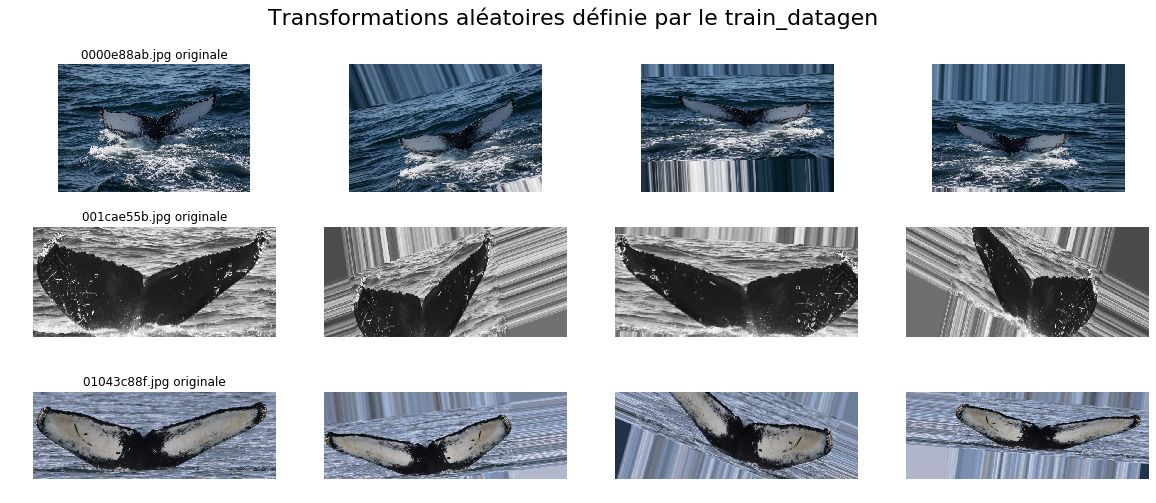

In [66]:
def affiche_transformation(l_index_image_dataSet):
    fig, ax = plt.subplots(3, 4, )
    ax = ax.ravel()
    fig.set_size_inches(20, 8, forward=True)
    #l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]
    idx_axe = 0

    for idx, idx_image in enumerate(l_index_image_dataSet):
        image_name = get_image_name_id_from_index(idx_image)
        ax[idx_axe].imshow(image_with_index(idx_image))
        ax[idx_axe].axis('off')
        ax[idx_axe].set_title('{} originale'.format(image_name))
        idx_axe+=1

        for i in range(3):
            ax[idx_axe].imshow(np.array(MyTransformation.transform(filename=image_name)))
            ax[idx_axe].axis('off')
            idx_axe+=1
    plt.suptitle('Transformations aléatoires définie par le train_datagen', fontsize=22)
    plt.show()

affiche_transformation([0, 10, 100, ])

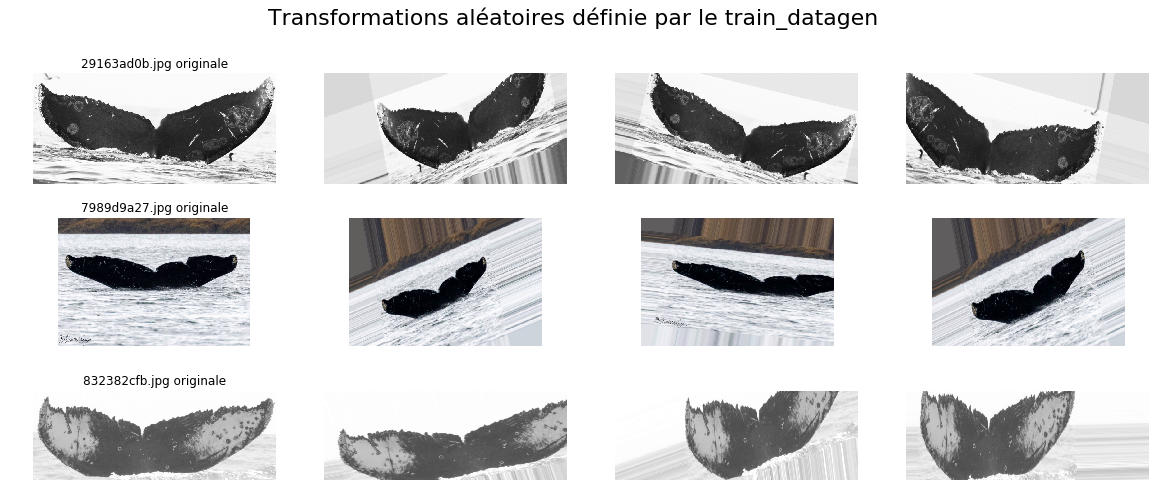

In [67]:
affiche_transformation([4000, 12000, 13000])

#### Très très peu d'Images

Nous avons aussi remarqué que de très nombreuses classes n'ont qu'une image, ou seulement 2 ou 3, ce qui est très peu.<br>
Un problème qui se pose notamment (en plus de la difficulté à optimisser la performance) est qu'il n'est même pas possible de réaliser les différentes phases que sont l'entrainement / la validation et optimisation et le test de performance du modèle avec si peu de données.

<div class="alert alert-block alert-info">
<b>Solution:</b> Dans ce cas aussi nous allons utiliser la `Data Augmentation` à partir des images peu représentées. Les images ainsi générées seront ajoutées au DataSet des images à utiliser.
</div>

#### Code de Génération des Images par Data Augmentation

```python

def genere_list_name_from_a_class(name, df, nb_to_create=5):
    '''Génération d'un DataFrame avec le nom des image à dupliquer'''
    l1 = list(df[df.Id==name].Image.values)*nb_to_create
    # On laisse jouer le random pour permuter les listes
    shuffle(l1)
    df_tmp = pd.DataFrame({'Image': l1[:nb_to_create]})
    df_tmp['Id'] = name
    return df_tmp

def create_df_with_image_to_augment(df_in, min_occurence=6):
    # On identifie l'occurrence de chaque classe
    frequences = df_in.Id.value_counts()
    
    # On ne traite que celles manquant d'images
    df_to_treat = frequences[frequences.values<min_occurence]
    
    l_df_with_names = []
    
    # On lance la génération d'image classe par classe
    for name, nb_occ in zip(df_to_treat.index, df_to_treat.values):
        tmp_df = genere_list_name_from_a_class(
            name, 
            df_in, 
            nb_to_create=min_occurence-nb_occ)
        l_df_with_names.append(tmp_df)
     
    # On renvoie le dataframe généré
    return pd.concat(l_df_with_names).reset_index(drop=True)

def genere_image_aug(df_in, myImageDataGenerator, min_occurence=6):
    '''Fonction qui 
    - recupere la liste des images a dupliquer
    - genere les nouvelles images
    - renvoie un dataframe avec les nouveau nom et les Id
    '''
    
    # Liste des images à dupliquer
    new_dataframe = create_df_with_image_to_augment(df_in, min_occurence=6)
    
    # Les Paths
    path_in='./../DATAS/data/train'
    path_out = './../DATAS/data/aug'

    # On Initialise la classe de tranformation des Images
    MyTransformation = TransformImage(
        train_datagen, 
        resize_max_pixel=300000, 
        dir_input=path_in, 
        dir_output=path_out, 
        prefix_rename='AUG')

    idx_nb_traite = 0
    l_new_name = []
    # On lance la transformation des Images
    for m_name, m_class in zip(new_dataframe.Image, new_dataframe.Id):
        idx_nb_traite+=1
        # Transformation aléatoire de l'image et sauvegarde 
        new_name = MyTransformation.transform_and_save(filename=m_name)
        l_new_name.append(new_name)
        
    return pd.DataFrame({'Image': l_new_name, 'Id': new_dataframe.Id})    

## Execution de la génération des Images
df_image_aug = genere_image_aug(df_train, train_datagen, min_occurence=6)

```

<a id='section3'></a>
# La Modélisation
-----

<a id='section3.1'></a>
## CNN

Comme nous l'avons dit nous utilisons un réseau convolutionel de neurones pour faire la classification de nos images.

Nous utilisons ici une solution de `Transfer Learning` à partir du VGG16 pré-entrainé sur les images d'ImageNet (base d'Images initiée par l'équipe de <b>Li Fei-Fei</b> de l'Université de Stanford).

![VGG16](Images/vgg16.png "VGG16")

Des tests ont aussi été réalisés via InceptionV3. 

<a id='section3.2'></a>
## Process

Nous séparons les données de train en 3 parties : `train (60%) / validation (20%) / split (20%`<br>
à l'aide de la fonction train_test_split par stratification, ce qui permet de ne pas avoir de classes non vues dans le train ou la validation ainsi que le fait de pouvoir tester toutes les classes.<br>

Nous passons ces ensembles dans un `ImageDataGenerator`, dans lequel nous appliquons de la Data Augmentation pour les données de Train, et rescallons toutes les données entre [0, 1]<br>

Les données alimentent ensuite le CNN après avoir été resizées en (224, 224) pour l'entrée dans le réseau de neurones.



<a id='section3.3'></a>
## Pré-Traitement sur les Images

Il est à noter que certaines images sont en niveau de gris (255 nuances de gris) et non en RGB.<br>
Cette opérations peut être réalisée en préprocessing par le générateur d'images.

De plus nous savons que pour l'insertion dans le réseau de neurones les images vont être redimensionnées.

L'entrainement des réseaux s'avère très lourd et coûteux en ressources et en temps.

Aussi afin de réduire un peu le temps d'entrainement les images ont toutes été modifiées 'une fois pour toute' afin de gagner du temps au chargement d'images sur des tailles que de toute façon nous savons que nous allons diminuer à chaque étape.

L'opération aurait pû être réalisées en python mais l'a été manuellement à partir de `convert` d'`Image Magick`
```bash 
ls $rep_in | while read toto
	do 
    convert -colorspace Gray $rep_in/$toto -resize 100000@ $rep_out/$toto 
    done
```
L'option -resize 100000@ appliquant un redimensionnement (conservant la résolution) tel que le nombre de pixels ne dépasse pas 100 000<br>
Les images sont donc toutes transformées en niveau de gris

<a id='section4'></a>
# Les Résultats de la modélisation
-----

<a id='section4.1'></a>
## L'entrainement

Les données ont été entrainées sur un serveur `p2.xlarge` chez `AWS EC2`.

Pour un nombre d'EPOCH allant jusqu'à 50 avec un nombre réduit d'images les temps de traitement ont été de 7h avec l'usage de GPU



<a id='section4.2'></a>
## Les Résultats

La modélisation de classification n'a pas donné de résultats satisfaisant.<br>
En effet l'accuracy relevée était très basse aux alentours de `acc: 0.1562` et les valeurs d'accuracy de validation restait autour de `val_acc: 2.1580e-04` sans évolution.

- Ce problème qui peut être lié à un problème de learning rate n'a pas été corrigé par le test de différentes valeurs de lr et différents optimizer ont été benchmarkés : RMSprop / Adam et SGD sans meilleur succés

In [80]:
import json

file1 = './AWS_JEUDI/GOOD/3_2_history_gpu_history.json'
file3 = './AWS_JEUDI/output/3_9_bis_INCEPTION_V3_history_gpu_history.json'

with open(file1, 'r') as f: data1 = json.loads(f.read())
with open(file3, 'r') as f: data3 = json.loads(f.read())
    
def affiche_graph(data, titre=''):
    def affiche_one(data, d_param):
        plt.plot(data[d_param['x_key']])
        plt.plot(data[d_param['y_key']])
        plt.title('model {}'.format(d_param['type_model']))
        plt.ylabel(d_param['type_model'])
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

    plt.figure(figsize=(15, 7), )
    plt.subplot(121)
    affiche_one(data, {'x_key': 'acc', 'y_key': 'val_acc', 'type_model': 'accuracy'})
    
    plt.subplot(122)
    affiche_one(data, {'x_key': 'loss', 'y_key': 'val_loss', 'type_model': 'loss'})
    plt.suptitle(titre, fontsize=12)
    plt.show()


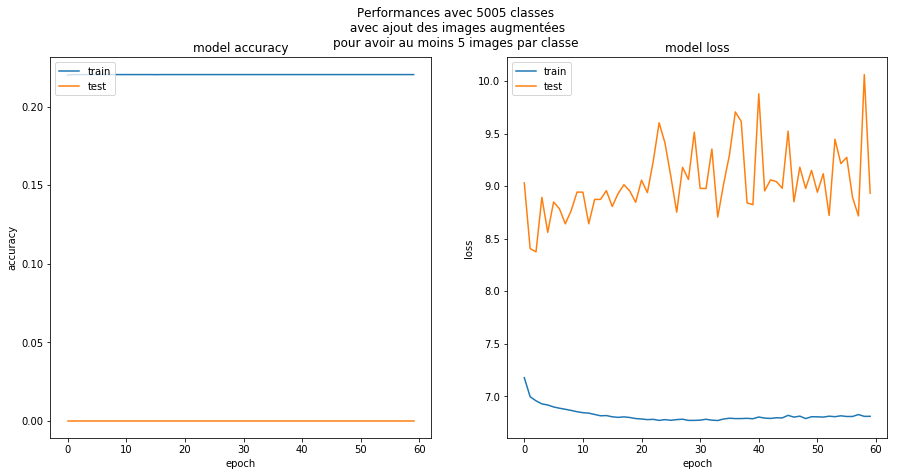

In [81]:
affiche_graph(data1, titre="Performances avec 5005 classes\n"
              " avec ajout des images augmentées\n"
              "pour avoir au moins 5 images par classe")

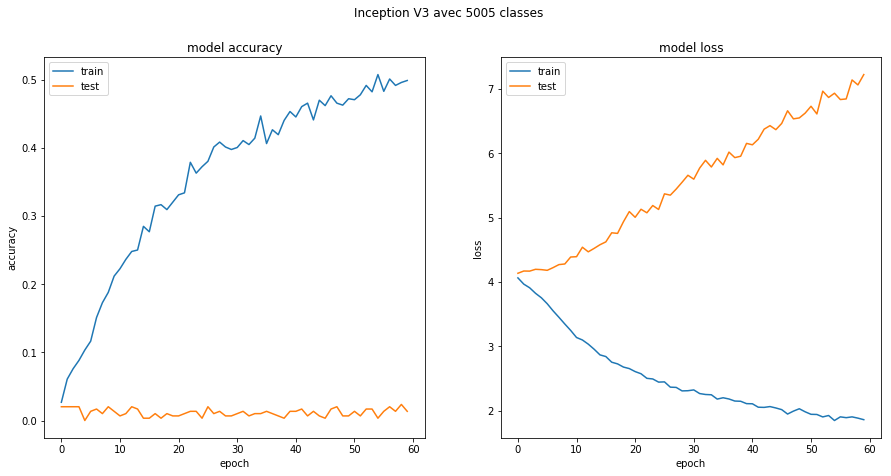

In [82]:
affiche_graph(data3, 'Inception V3 avec 5005 classes')

<a id='section4.3'></a>
## Faux Bon résultat

> Dans un but de tester le modèle sur des données qui permettent de montrer la performance dans certaines conditions (afin de vérifier qu'il n'y a pas de bug) un filtrage a été réalisé sur les données.

> Seules les classes ayant plus de 20 images sont prises en compte : cela concerne 60 classes différentes.

> A la suite de l'entrainement une accuracy de 0.83 a été obtenue pour l'entrainement comme la validation après 2 ECOCH.  🤗


![](Images/3_9.png "Version 3.9")

#### Analyse de la prédiction des données de test

In [109]:
file_test_9 = './AWS_JEUDI/output/3_9_BIS_DF_TEST_PREDICTION.csv'
file_prediction_challenge_9 = './AWS_JEUDI/output/3_9_BIS_DF_PREDICTION_CHALLENGE.csv'
file_test_11 = './AWS_JEUDI/output/3_11_DF_TEST_PREDICTION.csv'

df_test_9 = pd.read_csv(file_test_9, index_col=[0])
df_challenge_9 = pd.read_csv(file_prediction_challenge_9, index_col=[0])
df_test_11 = pd.read_csv(file_test_11, index_col=[0])


In [89]:
df_test_9.head()

,new_whale,w_789c969,w_fd3e556,w_e1ffbe2,w_ef83760,w_5a2634c,w_5773c71,w_51fc1fc,w_f0fe284,w_564a34b,...,w_08630fd,w_1ca9ab1,w_8da30ad,w_60cf87c,w_343f088,w_bfcad53,w_75f6ffa,w_0bc078c,Real_Class_Name,Real_Class_Id
4ced78cca.jpg,0.782884,0.002174,0.002813,0.002384,0.002800,0.004754,0.002783,0.006390,0.006073,0.004168,...,0.002318,0.003421,0.003646,0.003226,0.003159,0.003072,0.002068,0.002135,new_whale,0
b8de9430a.jpg,0.885274,0.001179,0.000877,0.001003,0.001705,0.001725,0.002122,0.001864,0.002339,0.001704,...,0.002087,0.001897,0.001656,0.001820,0.001382,0.001277,0.001172,0.001258,w_789c969,1
9fd6630a9.jpg,0.803480,0.001991,0.001523,0.002899,0.002318,0.005410,0.002404,0.004825,0.003030,0.003574,...,0.002636,0.003457,0.002010,0.004248,0.003873,0.002312,0.002415,0.002939,new_whale,0
57aabaa94.jpg,0.740258,0.002650,0.003231,0.002587,0.004099,0.005401,0.003328,0.004338,0.005931,0.003419,...,0.004492,0.003324,0.004062,0.005406,0.004554,0.004593,0.002664,0.004295,new_whale,0
b7decf2d2.jpg,0.857055,0.001632,0.001212,0.001616,0.002468,0.002433,0.001399,0.003866,0.003198,0.001993,...,0.002317,0.002552,0.001532,0.002435,0.001714,0.002078,0.001218,0.001678,new_whale,0


#### Fonction de Mesure d'une liste proposée pour une Image

<div class="alert alert-block alert-warning">
<b>Rappel de la formule de mesure</b>
$$MAP@5=\frac{1}{U}\sum_{u=1}^{U}\sum_{k=1}^{min(n,5)}P(k)×rel(k)$$<br>
</div>

In [91]:
def get_score_from_list(name_good_class, l_prediction):
    if name_good_class in l_prediction[:5]:
            return 1/(l_prediction.index(name_good_class)+1)
    else:
        return 0

#### Mesure d'une prédiction (à partir du label) par pourcentage de probabilité de prédiction

In [98]:
def get_mesure(df_test, threshold):
    '''
    Détermine la moyenne des MAP@5
    INPUT: 
        - df_test : le DataSet prédit à partir des données de test
        - threshold : seuil obtenu par 'new_whale' à partir duquel on met 'new_whale' en 1e position de la liste.
    '''
    l_col = list(df_test.columns)[:-2]

    id_2_name = dict()
    for nb, name in enumerate(l_col):
        id_2_name[nb] = name
    
    matrice = df_test.values[:, :-2]
    
    resultat_indices_meilleurs = np.argsort(matrice, axis=1)[::-1][:,:5]
    resultat_valeurs_meilleurs = np.sort(matrice, axis=1)[::-1][:,:5]

    l_res = []
    for i, val_new_whale in zip(resultat_indices_meilleurs, df_test['new_whale'].values):
        tmp1 = [id_2_name[x] for x in i]
        if (val_new_whale>threshold):
            tmp1 = ['new_whale'] + tmp1
        l_res.append(tmp1)

    y = list(df_test['Real_Class_Name'].values)

    l_mesure = []
    for good, predict in zip(y, l_res):
        l_mesure.append(get_score_from_list(good, predict))

    return np.mean(l_mesure)

Les mesures pour des threshold de 0.0, 0.9 et 1.0

In [113]:
get_mesure(df_test_9, 0.0), get_mesure(df_test_9, 0.9), get_mesure(df_test_9, 1.0),

(0.83480251860332, 0.03116771608471666, 0.008271322266742988)

#### Comparaison du score de test selon le threshold

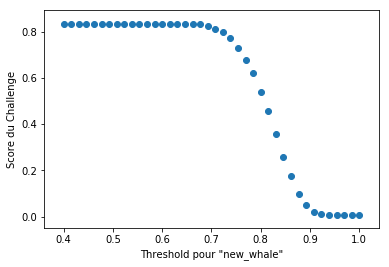

CPU times: user 1.53 s, sys: 3.98 ms, total: 1.53 s
Wall time: 1.53 s


In [116]:
%%time 

m_res = []
m_x = np.linspace(0.4, 1.0, num=40)
for i in m_x:
    m_res.append(get_mesure(df_test_9,i))
    
plt.scatter(x=m_x, y=np.array(m_res))
plt.xlabel('Threshold pour "new_whale"')
plt.ylabel('Score du Challenge')
plt.show()

> Dans ce cas de modélisation le seuil doit être fixé à 0.0 pour obtenir la meilleure note de 0.83.<br>
> Cela signifie donc que par rapport à la prédiction des données seule compte le fait de forcer la place de 'new_whale' en 1e place de la liste des proposition de toutes les lignes.

En regardant les données utilisées pour cet entrainement nous voyons

In [190]:
df_reparition_classes = df_train.Id.value_counts()
df_nb_plus_de_20_images = df_reparition_classes[df_reparition_classes>20]
pd.DataFrame({"Nombre d'images":df_nb_plus_de_20_images})[:5]

,Nombre d'images
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61


In [191]:
l_df_image_ok = []
for image_name in df_nb_plus_de_20_images.index:
    l_df_image_ok.append(df_train[df_train.Id==image_name])

df_classes_avec_beaucoup_images = pd.concat(l_df_image_ok)

In [193]:
df_classes_avec_beaucoup_images.head()

,Image,Id
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
7,000f0f2bf.jpg,new_whale
11,001d7450c.jpg,new_whale


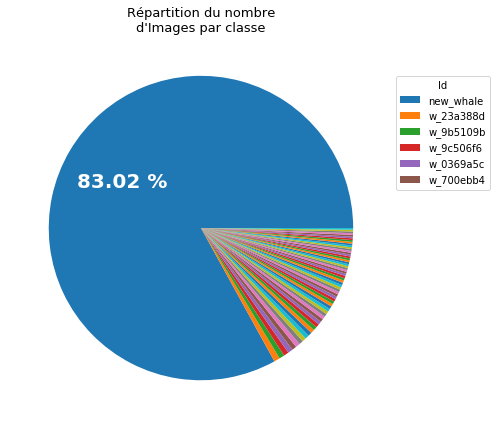

In [198]:
t6 = df_classes_avec_beaucoup_images.Id.value_counts()

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    if pct>10:
        return "{:.2f} %".format(pct)
    else: 
        return None

wedges, texts, autotexts = ax.pie(t6, autopct=lambda pct: func(pct, t6),
                                  textprops=dict(color="w"))

ax.legend(wedges, t6[t6.values>55].index,
          title="Id",
          loc="center left",
          bbox_to_anchor=(1, 0, 2.0, 1.5))

plt.setp(autotexts, size=20, weight="bold")

ax.set_title("Répartition du nombre\nd'Images par classe", fontsize=13)

plt.show()

> En fait les 83 % d'accuracy semblent très liés à la proportion des image de classe 'new_whale' par rapport aux autres images dans les données en entrées de la modélisation

In [261]:
def get_confusion_matrix(df_test):
    '''
    Détermine le label obtenant la meilleure probabilité de prédiction
    et renvoie la matrice de confusion 
    '''
    from sklearn.metrics import confusion_matrix
    l_col = list(df_test.columns)[:-2]

    id_2_name = dict()
    for nb, name in enumerate(l_col):
        id_2_name[nb] = name
    
    matrice = df_test.values[:, :-2]
    resultat_indices_meilleurs = np.argsort(matrice, axis=1)[::-1][:,0]    
    y_predict = np.array([id_2_name[i] for i in resultat_indices_meilleurs])
    y_true = df_test.Real_Class_Name.values
    
    cm = pd.DataFrame(confusion_matrix(y_true, y_predict))
    cm.columns = df_test.columns[:-2]
    cm.index = df_test.columns[:-2]
    
    return cm

In [264]:
cm_from_test_9 = get_confusion_matrix(df_test_9)

In [265]:
cm_from_test_9.head()

,new_whale,w_789c969,w_fd3e556,w_e1ffbe2,w_ef83760,w_5a2634c,w_5773c71,w_51fc1fc,w_f0fe284,w_564a34b,...,w_6caff0f,w_27597ff,w_08630fd,w_1ca9ab1,w_8da30ad,w_60cf87c,w_343f088,w_bfcad53,w_75f6ffa,w_0bc078c
new_whale,0,1,0,1,3,5,101,0,0,17,...,0,86,3,12,8,0,0,27,68,0
w_789c969,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
w_fd3e556,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
w_e1ffbe2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
w_ef83760,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
# Les classes les plus présentes dans les données prédites
np.sum(cm_from_test_9, axis=0).sort_values(ascending=False).head(10)

w_700ebb4    433
w_cd4cb49    207
w_9da1811    189
w_5773c71    135
w_27597ff    103
w_9c506f6     89
w_4516ff1     89
w_2b069ba     84
w_75f6ffa     82
w_17b0d3a     73
dtype: int64

In [282]:
# Les classes les plus présentes dans les données de test sont
np.sum(cm_from_test_9, axis=1).sort_values(ascending=False).head(10)

new_whale    1450
w_f765256      11
w_990921b      10
w_04003e9      10
w_bc285a6       9
w_fd3e556       9
w_efbdcbc       8
w_75f6ffa       8
w_0369a5c       8
w_9c506f6       8
dtype: int64

> En fait aucune 'new_whale' n'a été prédite 

<a id='section5'></a>
# CONCLUSION

La modélisation de classification par Transfer Learning n'a ici rien donné du fait des faibles scores obtenus.<br>
Cette étape étant nécessaire (par rapport à la stratégie proposée) pour l'élaboration d'une liste de prédiction, la suite de l'analyse n'a malheureusement pas pu aller plus loin.

Par la suite il faut identifier pour quelles raisons celle-ci n'a pas donné de résultat:
- la piste est à priori l'idée erronée que les réseaux choisis connaissent déjà les images de Baleines.
-> certe il y a des sections Baleine mais il n'est ) postériori pas sûr que celles-ci soient faite sur des détails de la queue des baleine.
- actuellement le site ImageNet est en maintenance et il ne m'a pas été possible de vérifier cela
- la solution pour reprendre la modélisation aurait donc été d'entrainer plus de niveaux (et pas uniquement celui de classification tel que cela a été fait) 


Ces doutes étant apparus tardivement (après plusieurs essais longs de modélisation) il ne semblait plus possible d'envisager cet entrainement supplémentaire.